## Goal

1. Find relationship between RS and RA to win %. Runs Scored, Runs Against and Win %

2. Possibly improve upon Pythagenpat formula

# Step 1

Obtain data from baseball reference

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

## Load and update team logs

In [2]:
def get_table(soup):
    data = []
    # Disclaimer: i used some of the code from pybaseball on github and modified the functions.
    table = soup.find_all('table', {'id': 'franchise_years'})[0]
    headings = [row.text.strip() for row in table.find_all('th')[0:21]]

    rows = table.find_all('tr')[1:] # [1:] to remove headings from rows
    for row in rows:
        year = row.find('th').text
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        cols.insert(0, year) # insert year at beginning of columns
        data.append([ele for ele in cols[0:]])
        
    data = pd.DataFrame(data=data, columns=headings)    

    return data

In [3]:
def player_batting_bref(team_id):
    # Disclaimer: i used some of the code from pybaseball on github and modified the functions.
    url = 'https://www.baseball-reference.com/teams/'+team_id +'/index.shtml'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    data = get_table(soup)
    
    return data

In [4]:
def give_me_df(team_ids):
    # Disclaimer: i used some of the code from pybaseball on github and modified the functions.
    master = pd.DataFrame()

    for team in team_ids:

        df= player_batting_bref(team_ids)
        master = master.append(df)

#        master['player_name'].fillna(player, inplace=True)
    
    master.reset_index(drop=True,inplace=True)
    
    return master

### I am scraping this web-page but for every team in the mlb.

In [5]:
url =  'https://www.baseball-reference.com/teams/TOR/index.shtml'
response = requests.get(url)
soup = BeautifulSoup(response.content,'html.parser')

In [6]:
teams = ['LAD','HOU','MIN','NYY','TBD','CHC','PHI','MIL','ATL','COL','TEX','BOS','STL','SDP','CLE','OAK'
    ,'ARI','CHW','ANA','PIT','NYM','CIN','WSN','SFG','DET','SEA','FLO','TOR'
        ,'BAL','KCR']

In [7]:
df1= pd.DataFrame()
for team in teams:
    try:
        df1 = df1.append(give_me_df(team))
        print('PASSED WITH TEAM :',team)
    except:
        print('FAILED WITH TEAM ',team)
        pass

PASSED WITH TEAM : LAD
PASSED WITH TEAM : HOU
PASSED WITH TEAM : MIN
PASSED WITH TEAM : NYY
PASSED WITH TEAM : TBD
PASSED WITH TEAM : CHC
PASSED WITH TEAM : PHI
PASSED WITH TEAM : MIL
PASSED WITH TEAM : ATL
PASSED WITH TEAM : COL
PASSED WITH TEAM : TEX
PASSED WITH TEAM : BOS
PASSED WITH TEAM : STL
PASSED WITH TEAM : SDP
PASSED WITH TEAM : CLE
PASSED WITH TEAM : OAK
PASSED WITH TEAM : ARI
PASSED WITH TEAM : CHW
PASSED WITH TEAM : ANA
PASSED WITH TEAM : PIT
PASSED WITH TEAM : NYM
PASSED WITH TEAM : CIN
PASSED WITH TEAM : WSN
PASSED WITH TEAM : SFG
PASSED WITH TEAM : DET
PASSED WITH TEAM : SEA
PASSED WITH TEAM : FLO
PASSED WITH TEAM : TOR
PASSED WITH TEAM : BAL
PASSED WITH TEAM : KCR


In [8]:
df1 = df1.drop_duplicates()

In [9]:
df1.columns

Index(['Year', 'Tm', 'Lg', 'G', 'W', 'L', 'Ties', 'W-L%', 'pythW-L%', 'Finish',
       'GB', 'Playoffs', 'R', 'RA', 'Attendance', 'BatAge', 'PAge', '#Bat',
       '#P', 'Top Player', 'Managers'],
      dtype='object')

In [10]:
df1.shape

(2684, 21)

In [11]:
df1_reserve = df1.copy()

### Preview:

This is basically what was scrapped

In [47]:
df1_reserve.sample(3)

,Year,Tm,Lg,G,W,L,Ties,W-L%,pythW-L%,Finish,...,Playoffs,R,RA,Attendance,BatAge,PAge,#Bat,#P,Top Player,Managers
109,1910,Cleveland Naps,AL,161,71,81,9,.467,.418,5th of 8,...,,548,657,"293,456",28.2,26.6,44,14,N.Lajoie (9.8),D.McGuire (71-81)
97,1922,Brooklyn Robins,NL,155,76,78,1,.494,.493,6th of 8,...,,743,754,"498,865",30.1,28.8,31,12,D.Ruether (5.1),W.Robinson (76-78)
22,1997,Los Angeles Dodgers,NL West,162,88,74,0,.543,.564,2nd of 4,...,,742,645,"3,319,504",29.3,28.8,44,16,M.Piazza (8.7),B.Russell (88-74)


In [12]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [13]:
df1.R = df1.R.astype(int)
df1.RA = df1.RA.astype(int)
df1.G = df1.G.astype(int)
df1['W-L%'] = df1['W-L%'].astype(float)
df1['W-L%'] = df1['W-L%'] * 100

# Step 2: TEST TRAIN SPLIT

In [14]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
            df1[['R','RA','G']], df1['W-L%'], test_size=0.30, random_state=42)

## Step 3: running a few machine learning regression models

In [15]:
decision_tree = tree.DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators = 100, random_state= 0)
ada = AdaBoostRegressor(random_state =0)
LR = LinearRegression()

decision_tree.fit(x_train[['R','RA']], y_train)
rf.fit(x_train[['R','RA']],y_train)
ada.fit(x_train[['R','RA']],y_train)
LR.fit(x_train[['R','RA']],y_train)

dt_preds = decision_tree.predict(x_test[['R','RA']])
rf_preds = rf.predict(x_test[['R','RA']])
ada_preds = ada.predict(x_test[['R','RA']])
LR_preds = LR.predict(x_test[['R','RA']])

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [16]:
mean_absolute_error(y_test, dt_preds), mean_absolute_error(y_test, rf_preds), mean_absolute_error(y_test, ada_preds), mean_absolute_error(y_test, LR_preds)

(2.9905707196029776, 2.2975855547678123, 2.6374765403263476, 2.148669043089457)

## Step 4: Comapring Mean Squared Error

MSE is better then mean absolute error. Take for example 2 points and a non-vertical line that seperates them. It won't matter if you move your line an inch above or below where it is... as long as it's in between the points the mean absolute error will stay the same (because it just calculates NET distance, so if one of the distances gets shorter but the other one gets longer it will come back to the same)... We need to do better which is why we use Mean Squared Error (MSE) MSE will penalize the points furter away so we will get 1 and only 1 solution which minimizes this.

In [17]:
mean_squared_error(y_test, dt_preds), mean_squared_error(y_test, rf_preds), mean_squared_error(y_test, ada_preds), mean_squared_error(y_test, LR_preds)

(14.172586848635236, 8.500926903718941, 11.34323490144544, 7.580158031495682)

### Getting the Error:

You can take the squared root of the MSE to get the error, here we notice that for Random Forest the error is 2.91% and for Linear regression (multiple linear regression) its 2.75% a pretty solid result

In [18]:
mean_squared_error(y_test, rf_preds)**0.5, mean_squared_error(y_test, LR_preds)**0.5 

(2.9156349057656277, 2.7532086792496644)

## Step 5 finding the MSE with the Pythagenpat and Pythagenport equations.

Pythagenpat is better then Pythagenport... lets confirm this

### Pythagenpat exploration

win % = rs ^ X / (rs ^ X + ra ^ X)   

Pythagenpat (apparently best version) X = ( (rs + ra)/g ) ^0.285

but generally: X = ((rs + ra)/g) ^ something

Lets iterate through all the decimals and find the best exponent for our test set

In [19]:
results = pd.DataFrame()
row = 0
for i in range(100,950):
    x_test['X_pyth'] = ((x_test.R + x_test.RA)/x_test.G)**(i/1000)
    x_test['W%_pyth'] = (x_test.R**x_test.X_pyth) / ( x_test.R**x_test.X_pyth + x_test.RA**x_test.X_pyth)
    results.loc[row,'i_exponent'] = i
    results.loc[row,'MSE'] = mean_squared_error(y_test, x_test['W%_pyth']*100)
    row = row + 1

In [20]:
results.sample(3)

,i_exponent,MSE
24,124.0,10.960014
144,244.0,6.737588
157,257.0,6.591352


,i_exponent,MSE
173,273.0,6.523659


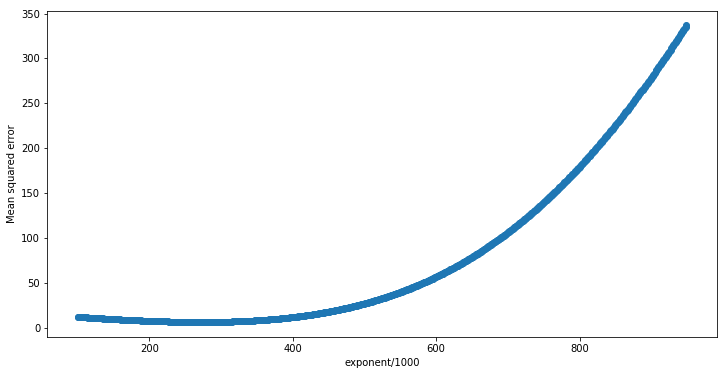

In [21]:
plt.figure(figsize=(12,6))
plt.scatter(results.i_exponent, results.MSE)
plt.xlabel('exponent/1000')
plt.ylabel('Mean squared error')

results[results.MSE==results.MSE.min()]

In [22]:
results.MSE.min()**0.5

2.55414551338183

### Pythagenpat results:

As we can see, the MSE is 6.5236 which is better then our Multiple Linear Regression. Grabbing the square root gets us 2.554 %

### Pythagenport exploration

win % = rs ^ x / (rs ^ x + ra ^ x)   tested for run environments between 4 and 40
where X = 2 or 1.83
<br> Again we will iterate through a bunch of exponents and find the best one

In [23]:
results2 = pd.DataFrame()
row = 0
for power in range(150,250):
    results2.loc[row,'power'] = power
    results2.loc[row,'MSE'] = mean_squared_error(y_test, (x_test.R**(power/100)/(x_test.R**(power/100)+x_test.RA**(power/100)))* 100)
    row += 1

In [24]:
results2.loc[results2.MSE ==results2.MSE.min()]

,power,MSE
32,182.0,6.551053


In [25]:
results2.query('power == 200')

,power,MSE
50,200.0,7.062826


### Pythagenport results:

As expected, the pythagenport MSE is better then the Multiple Linear regression but slightly higher then Pythagenpart. The optimal exponent is 1.82 but there isn't that much of a difference between 1.82 and 2 which I believe was traditionally used.

## Conclusion so far:

Yes, this is consistent with the current litterature... Pythagenpat is the best formula/function to predict Win %. We can see the root mean squared error is 6.52 vs 6.55 for PythagenPort. With lienar regression, we were only able to obtain a MSE of 7.5. Other standard machine learning models all had MSE greater then 7.5, all this means is that Pythagenpat is the best estimator we have so far.

Pythagenpat: https://legacy.baseballprospectus.com/glossary/index.php?mode=viewstat&stat=136
<br>Pythagenport: https://legacy.baseballprospectus.com/glossary/index.php?search=pythagenport

## Part 6: grid search on RandomForest to see if we can improve it 

In [26]:
%%time
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV

#the best model was the Random Forest Classifier

# TODO: Initialize the classifier
clf = RandomForestRegressor(n_estimators= 100,random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'n_estimators': [100,200], 
              'min_samples_split' : [2,10,20], 
              'min_samples_leaf' :  [2,10,20],
              }

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring='neg_mean_squared_error', cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(x_train[['R','RA']], y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(x_train[['R','RA']], y_train)).predict(x_test[['R','RA']])
best_predictions = best_clf.predict(x_test[['R','RA']])

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("MSE score on testing data: {:.7f}".format(mean_squared_error(y_test, predictions)))
print("\nOptimized Model\n------")
print("MSE score on the testing data: {:.7f}".format(mean_squared_error(y_test, best_predictions)))
print(best_clf)

Unoptimized model
------
MSE score on testing data: 8.5009269

Optimized Model
------
MSE score on the testing data: 7.8760835
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
Wall time: 25.8 s


### Results:
MSE on optimized model is still higher then LR and obviously higher then Pythagenpat

## Step 7: Running a quick Neural Network

#### I will be using the same training and testing set. I modified it earlier above so here I am going to clean them. I also want to have my y_train and y_test which contain the w%, I want to bound this between 0-1... more on this later

In [29]:
x_train2 = x_train.drop('G', axis=1)
x_test2  = x_test.drop(['G','X_pyth','W%_pyth'], axis = 1)

In [32]:
y_train = y_train/100
y_test = y_test/100

### importing the proper libraries for PyTorch

In [33]:
import torch   #imports PyTorch
from torch import nn, optim
import torch.nn.functional as F
import time

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name()

'GeForce GTX 1050'

### Creating my neural net:

the last hidden layer has a Sigmoid function which bounds the result from 0-1 which is why I wanted my win% in y_train and y_test to be between 0-1

In [35]:
class model_classifier(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output = 1):
        super().__init__()
        self.hidden = nn.Linear(n_feature, n_hidden)
        self.hidden2 = nn.ReLU()
        self.hidden3 = nn.Linear(n_hidden, 20)
        self.hidden4 = nn.Tanh()
        self.hidden5 = nn.Linear(20, 3)
        self.hidden6 = nn.Sigmoid()
        self.predict = nn.Linear(3, n_output)
        
        self.dropout = nn.Dropout(p=0)
        
    def forward(self, x):
                
        x = self.hidden(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.hidden6(x)
        
        x = self.predict(x)
        
        return x

In [36]:
model = model_classifier(n_feature = x_train2.shape[1], n_hidden = 40, n_output = 1)

optimizer = optim.Adam(model.parameters(), lr = 0.00001)

criterion = nn.MSELoss()

model.to(device);

In [37]:
epochs = 100000
model.to(device);

x_train_tensor = torch.tensor(x_train2.values).float().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)

x_test_tensor = torch.tensor(x_test2.values).float().to(device)
y_test_tensor = torch.tensor(y_test.values).float().to(device)

train_loss_records, test_loss_records = [], []
model.train()
for epoch in range(0,epochs):
    running_loss = 0
    
    optimizer.zero_grad()
    
    output = model(x_train_tensor)
    y_train_tensor =  y_train_tensor.view(*output.shape)
    loss = criterion(output,y_train_tensor)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    train_loss_records.append(running_loss)
    
    model.eval()
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        
        output2 = model(x_test_tensor)
        y_test_tensor = y_test_tensor.view(*output2.shape)
        test_loss += criterion(output2, y_test_tensor)
        
        test_loss_records.append(test_loss.item())
    
    model.train()
    
    if ((epoch+1) % 10000) == 0:
        print('Round', epoch+1)
print('COMPLETE')

Round 10000
Round 20000
Round 30000
Round 40000
Round 50000
Round 60000
Round 70000
Round 80000
Round 90000
Round 100000
COMPLETE


In [38]:
tls = pd.DataFrame(train_loss_records)
tls.rename(columns={0:'MSE'}, inplace=True)
testlr = pd.DataFrame(test_loss_records)
testlr.rename(columns={0:'MSE'}, inplace=True)

### Neural Net results

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


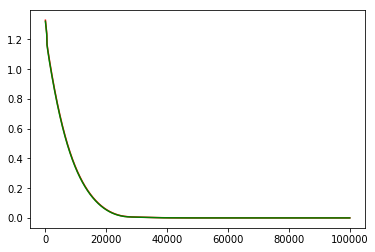

In [39]:
plt.plot(tls, label='Training_loss', color='r')
plt.plot(testlr, label='Test_loss', color='g')
print(optimizer)

In [43]:
testlr.tail()  #stands for test losses, this gets me the last 5 values at the end...

,MSE
99995,0.00068
99996,0.00068
99997,0.00068
99998,0.00068
99999,0.00068


In [41]:
testlr[testlr.MSE == testlr.MSE.min()]

,MSE
54654,0.000679


This is the same as a MSE of 6.59 if our W% hadnt been scaled from 0 to 100% to 0 to 1

In [42]:
print((0.000659**0.5 * 100)**2),  # last time I got this result...
print((0.0006695**0.5 * 100)**2)

6.589999999999999
6.695000000000001


### Conclusion: 

We got very close to Pythagenpat which had a MSE of 6.52, I don't know why its different. Will continue this research later.

Now we basically have a model and we can input the Runs Scored and Runs Against and obtain a very accurate Win % estimator.

The reason we obtain errors is that the amount of wins and losses isn't 100% related to the amount of runs scored and runs against, for example consider a team winning 13-0 and losing the next game 0-1... now repeat these games multiple times and the team would have scored 13\*n runs and would have allowed 1\*n... their record would be 50% yet the Pythagenpat and our neural net model would surely predict a very high win-rate... 

<br>So yes, runs scored and runs against is not a perfect model but having an error of 2.55% is pretty good. So 66% of the time the error will be +-2.55%, 95% it will be +-5% and 99.9% of the time it will be at +-7.5%. 2.5% translates to 4 games which means that 99.9% of the time the team's actual amount of wins will vary by 12 games on the upside or 12 games on the downside.

Henry